In [26]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import os

In [27]:
# Define the Dataset class
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0] + ".png")
        image = Image.open(img_name)
        label = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [28]:
# Define the image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    #transforms.Resize((224, 224))
])

# Load the test dataset
test_images_directory = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'preprocessed_test_images')
test_csv_file = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'binary_test.csv')

test_dataset = FundusDataset(csv_file=test_csv_file, img_dir=test_images_directory, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [29]:
# Load the ResNet-18 model architecture
model = models.resnet18(pretrained=False)  # Set pretrained=False because we're loading custom weights
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Replace the final layer with the same configuration as before

c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:
# Load the trained weights
trained_resnet_model = os.path.join('..', '..', 'Models', 'resnet18_fundus_binaryCV.pth')
model.load_state_dict(torch.load(trained_resnet_model))

# Set the model to evaluation mode
model.eval()

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to store true labels and predictions
all_labels = []
all_preds = []
all_probs = []

C:\Users\Kaylin\AppData\Local\Temp\ipykernel_11072\924893159.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_resnet_model))


In [31]:
# Testing loop
with torch.no_grad():  # Disable gradient calculation for testing
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [32]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 93.17%


In [33]:
# Calculate F1 score
f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.93


In [34]:
# Calculate Precision and Recall
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.89
Recall: 0.98


In [35]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.98


In [36]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       199
         1.0       0.89      0.98      0.93       167

    accuracy                           0.93       366
   macro avg       0.93      0.94      0.93       366
weighted avg       0.94      0.93      0.93       366



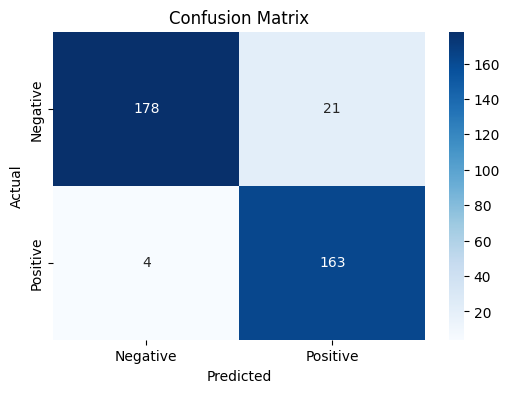

In [37]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

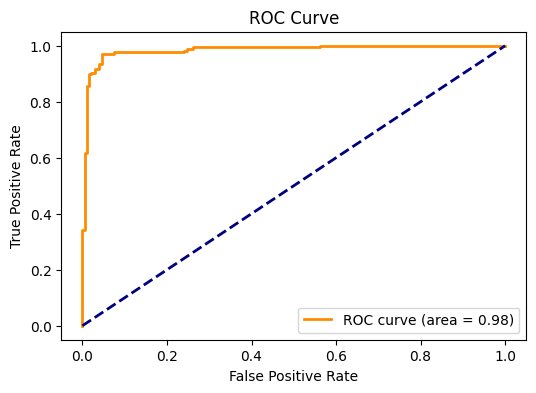

In [38]:
# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

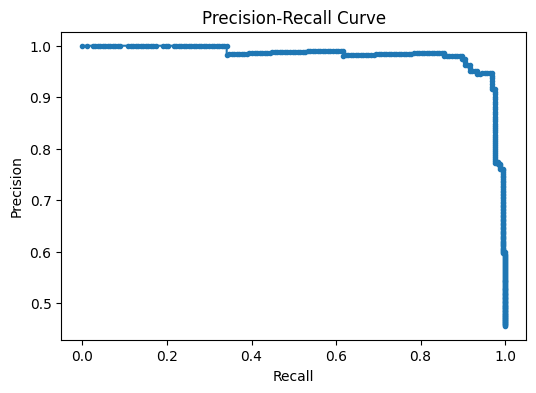

In [39]:
# Precision-Recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()